<a href="https://colab.research.google.com/github/Wanita-8943/efficientnet_keras_transfer_learning/blob/master/%E0%B9%82%E0%B8%AD%E0%B9%80%E0%B8%84_1F_MAE_dataframe_Female_500.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#เรียกใช้ CSV

In [21]:
import pandas as pd
import shutil

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Imports

In [23]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import os
import glob
import shutil
import sys
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

In [24]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

#กำหนดค่าพารามิเตอร์


In [25]:
batch_size = 16
width = 150
height = 150
epochs = 500
NUM_TRAIN = 1425
NUM_TEST = 475
dropout_rate = 0.2
input_shape = (height, width, 3)

#Clone efficientnet repo


In [26]:
#ดึงข้อมูลใน Github มาใช้
import os
%cd /content
if not os.path.isdir("efficientnet_keras_transfer_learning"):
 !git clone https://github.com/Wanita-8943/efficientnet_keras_transfer_learning
%cd efficientnet_keras_transfer_learning/


/content
/content/efficientnet_keras_transfer_learning


In [27]:
# Options: EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3
# Higher the number, the more complex the model is.
from efficientnet import EfficientNetB0 as Net
from efficientnet import center_crop_and_resize, preprocess_input

In [28]:
# loading pretrained conv base model
# โหลดโมเดล มาโดยตัด output ของโมเดลออก เเต่ยังใช้ input อันเดิม
# เเละโหลด weight ของโมเดล มาด้วยที่ชื่อว่า imagenet
conv_base = Net(weights='imagenet', include_top=False, input_shape=input_shape)

In [29]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D(name="gap"))
# model.add(layers.Flatten(name="flatten"))
if dropout_rate > 0:
    model.add(layers.Dropout(dropout_rate, name="dropout_out"))
# model.add(layers.Dense(256, activation='relu', name="fc1"))
model.add(layers.Dense(19, activation='softmax', name="fc_out"))
model.add(layers.Dense(1))

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functional  (None, 5, 5, 1280)       4049564   
 )                                                               
                                                                 
 gap (GlobalMaxPooling2D)    (None, 1280)              0         
                                                                 
 dropout_out (Dropout)       (None, 1280)              0         
                                                                 
 fc_out (Dense)              (None, 19)                24339     
                                                                 
 dense_1 (Dense)             (None, 1)                 20        
                                                                 
Total params: 4,073,923
Trainable params: 4,031,907
Non-trainable params: 42,016
_______________________________________

In [31]:
print('This is the number of trainable layers '
      'before freezing the conv base:', len(model.trainable_weights))

conv_base.trainable = False

print('This is the number of trainable layers '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable layers before freezing the conv base: 215
This is the number of trainable layers after freezing the conv base: 4


In [32]:
conv_base.summary() #ดู Summary

Model: "efficientnet-b0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_65 (Conv2D)             (None, 75, 75, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_49 (BatchN  (None, 75, 75, 32)  128         ['conv2d_65[0][0]']              
 ormalization)                                                                                    
                                                                                    

#สร้างโฟลเดอร์ Train Valodation และ Test

In [33]:
df = pd.read_csv (r'/content/drive/MyDrive/cut_panoramic/Data/New_Data_Female125.csv')
df

,Fig_Age,Fig_Person_Sex,Age(year),Class,Class_Re,Filename,Path_filename,Sex,Floder
0,1,1,7,Y07F,0,V1.jpg,/content/drive/My Drive/TVT_Female125/train/Y0...,Female,Both
1,2,1,7,Y07F,0,Flip_V1.jpg,/content/drive/My Drive/TVT_Female125/train/Y0...,Female,Both
2,3,2,7,Y07F,0,V2.jpg,/content/drive/My Drive/TVT_Female125/train/Y0...,Female,Both
3,4,2,7,Y07F,0,Flip_V2.jpg,/content/drive/My Drive/TVT_Female125/train/Y0...,Female,Both
4,5,3,7,Y07F,0,V3.jpg,/content/drive/My Drive/TVT_Female125/train/Y0...,Female,Both
...,...,...,...,...,...,...,...,...,...
2370,121,65,25,Y25F,18,Flip_J145.jpg,/content/drive/My Drive/TVT_Female125/test/Y25...,Female,Lt
2371,122,66,25,Y25F,18,Flip_J149.jpg,/content/drive/My Drive/TVT_Female125/test/Y25...,Female,Lt
2372,123,67,25,Y25F,18,Flip_J158.jpg,/content/drive/My Drive/TVT_Female125/test/Y25...,Female,Lt
2373,124,68,25,Y25F,18,Flip_J177.jpg,/content/drive/My Drive/TVT_Female125/test/Y25...,Female,Lt


In [34]:
train = df[df['Fig_Age'].between(1,75)]
val = df[df['Fig_Age'].between(76,100)]

In [35]:
DATA_PATH = "/content/drive/My Drive/TVT_Female125"
os.chdir(DATA_PATH)
train_dir = os.path.join(DATA_PATH, 'train')
print(train_dir)
validation_dir = os.path.join(DATA_PATH, 'validation')
print(validation_dir)

/content/drive/My Drive/TVT_Female125/train
/content/drive/My Drive/TVT_Female125/validation


In [36]:
# base_dir = '/content/drive/MyDrive/TVT_Male125'
# os.makedirs(base_dir, exist_ok=True)

# # Directories for our training,
# # validation and test splits
# train_dir = os.path.join(base_dir, 'train')
# os.makedirs(train_dir, exist_ok=True)
# validation_dir = os.path.join(base_dir, 'validation')
# os.makedirs(validation_dir, exist_ok=True)
# test_dir = os.path.join(base_dir, 'test')
# os.makedirs(test_dir, exist_ok=True)


#Train

In [37]:
# Train ด้วย ImageDataGenerator ของ Keras ซึ่งจะเพิ่มข้อมูลเสริมระหว่างการฝึกเพื่อลดโอกาสเกิด overfitting
#overfitting เกิดจากข้อมูลที่ซับซ้อนกันเกินไป
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255, #โมเดลส่วนใหญ่ต้องใช้ RGB ในช่วง 0–1
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

In [38]:
train_generator = train_datagen.flow_from_dataframe(
        dataframe = train,
        directory = train_dir,
        x_col = 'Path_filename',
        y_col = 'Class_Re',
        class_mode = 'other',
        target_size=(height, width),
        batch_size=batch_size)

validation_generator = test_datagen.flow_from_dataframe(
        dataframe = val,
        directory = validation_dir,
        x_col = 'Path_filename',
        y_col = 'Class_Re',
        class_mode = 'other',
        target_size=(height, width),
        batch_size=batch_size)

Found 1425 validated image filenames.
Found 475 validated image filenames.


In [39]:
model.compile(loss='mse',
          optimizer=Adam(lr=2e-6),
          metrics=['mae'])
history = model.fit_generator(
      train_generator,
      steps_per_epoch= NUM_TRAIN //batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps= NUM_TEST //batch_size,
      verbose=1,
      use_multiprocessing=True,
      workers=4)

<ipython-input-39-90b2ae0efec2>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/500
89/89 [==============================] - 37s 288ms/step - loss: 100.5833 - mae: 8.4631 - val_loss: 98.5220 - val_mae: 8.3308
Epoch 2/500
89/89 [==============================] - 21s 227ms/step - loss: 97.1091 - mae: 8.2803 - val_loss: 96.9640 - val_mae: 8.2724
Epoch 3/500
89/89 [==============================] - 23s 254ms/step - loss: 94.4401 - mae: 8.1272 - val_loss: 92.9357 - val_mae: 8.0455
Epoch 4/500
89/89 [==============================] - 27s 293ms/step - loss: 91.0390 - mae: 7.9558 - val_loss: 89.5545 - val_mae: 7.8828
Epoch 5/500
89/89 [==============================] - 25s 281ms/step - loss: 89.0676 - mae: 7.8587 - val_loss: 87.2756 - val_mae: 7.7674
Epoch 6/500
89/89 [==============================] - 29s 314ms/step - loss: 86.5204 - mae: 7.7245 - val_loss: 84.8174 - val_mae: 7.6451
Epoch 7/500
89/89 [==============================] - 25s 272ms/step - loss: 83.2974 - mae: 7.5557 - val_loss: 82.4727 - val_mae: 7.5131
Epoch 8/500
89/89 [============================

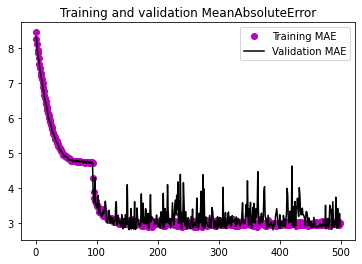

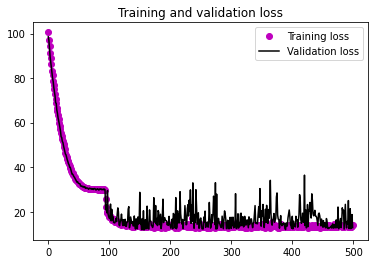

In [43]:
loss = history.history['loss']
val_loss = history.history['val_loss']
mae = history.history['mae']
val_mae = history.history['val_mae']


epochs_x = range(len(loss))


plt.plot(epochs_x, mae, 'mo', label='Training MAE')
plt.plot(epochs_x, val_mae, 'k', label='Validation MAE')
plt.title('Training and validation MeanAbsoluteError')
plt.legend()

plt.figure()
plt.plot(epochs_x, loss, 'mo', label='Training loss')
plt.plot(epochs_x, val_loss, 'k', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [41]:
epochs_x

range(0, 500)

#Download the model


In [42]:
os.makedirs('/content/drive/My Drive/cut_panoramic/Model', exist_ok=True)
model.save('/content/drive/My Drive/cut_panoramic/Model/1_New_MAE_Flimpano_Female18_500.h5')

In [ ]:
# from google.colab import files
# files.download('/content/drive/My Drive/cut_panoramic/Model/1.1_รอบแรก_Flimpano_Male125_250.h5')